In [15]:
# Tugas Besar IF3270 Pembelajaran Mesin
# Anggota Kelompok:
# 1. Gede Prasidha Bhawarnawa - 13520004

# Section Tugas Besar A: Implementasi Forward Propagation untuk Feed Forward Neural Network (FFNN)

# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Softmax Activation Function Implementation
def softmax(arr):
    numerator = np.exp(arr)
    denominator = np.sum(numerator)
    return numerator / denominator

In [3]:
# Sigmoid Activation Function Implementation
def sigmoid(arr):
    numerator = np.exp(arr)
    denominator = numerator + 1
    return numerator / denominator

In [4]:
# Linear Activation Function Implementation
def linear(arr):
    return arr

In [5]:
# Rectified Linear Unit (ReLU) Activation Function Implementation
def relu(arr):
    for i in range(len(arr)):
        if arr[i] < 0:
            arr[i] = 0
    return arr

In [6]:
# Format for the model input:

# number_of_layers(INT)
# number_of_nodes_in_layer_1(INT)
# number_of_nodes_in_layer_2(INT)
# ...
# number_of_nodes_in_layer_n(INT)
# number_of_output_nodes(INT)
# loop for all nodes except output (
# node_number, node_type, node_level, node_value, activation_function, node_weight_1, node_weight_2, ..., node_weight_n
# )

# Number of layers doesn't include the input layer and the output layer
# When counting input_nodes, include the bias node also.
# There are four node_types: bias, input, hidden
# If the node_type is bias, then the node_value must be 1 or the program will exit with error message. It's activation function doesn't matter
# If the node_type is input, then the node_value must be the input value and the node_level must be 0. It's activation function doesn't matter
# If the node_type is hidden, then the node_value doesn't matter and the node_level must be greater than 0
# Output nodes will be created automatically based on the number of output nodes
# All counts start from 0, including the node_level and node_numbering (will be done behind-the-scenes)
# The activation_function must be one of the following: linear, sigmoid, relu, softmax
# The number of node_weights declared in each node must be the same as the number of nodes in the next layer/level
# Note: For each node information, DO NOT USE WHITESPACES

# Example:

# 2 (number_of_layers)
# 3 (number_of_nodes_in_layer_1)
# 2 (number_of_nodes_in_layer_2)
# 2 (number_of_output_nodes)
# 0,bias,0,1,linear,4:0.5,5:-0.2,6:0.3 (bias input node in layer 1)
# 1,input,0,12,linear,4:0.2,5:-0.1,6:0.1 (#1 input node in layer 1)
# 2,input,0,3,linear,4:0.1,5:0.2,6:0.3 (#2 input node in layer 1)
# 3,bias,1,1,linear,8:0.1,9:0.2 (bias input node in layer 2)
# 4,hidden,1,0,linear,8:0.1,9:0.2 (#1 hidden node in layer 2)
# 5,hidden,1,0,relu,8:-0.4,9:-0.7 (#2 hidden node in layer 2)
# 6,hidden,1,0,softmax,8:0.5,9:-0.3 (#3 hidden node in layer 2)
# 7,bias,2,1,linear,10:0.1,11:0.2 (bias input node in layer 3)
# 8,hidden,2,0,linear,10:0.2,11:0.1 (#1 hidden node in layer 3)
# 9,hidden,2,0,relu,10:-0.1,11:-0.1 (#2 hidden node in layer 3)

# For the case above, total number of nodes declared in the text file is 10
# The number of nodes in each layer is 3, 4, 3
# Again note that no output nodes are declared in the text file, they will be created automatically

In [19]:
# Node Class and Instances
class Node:
    def __init__(self, node_number, node_type, node_level, activation_function, weight, node_value=0):
        self.node_number = node_number
        self.node_type = node_type
        self.node_value = node_value # For non-input nodes, this value is 0
        self.node_level = node_level
        self.activation_function = activation_function
        self.weight = weight
        self.output = 0
        self.error = 0
    
    def getNodeNumber(self):
        return self.node_number
    
    def getNodeType(self):
        return self.node_type
    
    def getNodeValue(self):
        return self.node_value
    
    def getNodeLevel(self):
        return self.node_level
    
    def getActivationFunction(self):
        return self.activation_function
    
    def getWeight(self):
        return self.weight
    
    def getStrWeight(self):
        return str(self.weight)
    
    def getNextLayerNodeNumbers(self, nodes):
        next_layer_nodes = []
        for node in nodes:
            if node.getNodeLevel() == self.node_level + 1:
                next_layer_nodes.append(node.getNodeNumber())
        return next_layer_nodes
    
    def getNodeInfo(self):
        print("Node Number: ", self.node_number)
        print("Node Type: ", self.node_type)
        print("Node Value: ", self.node_value)
        print("Node Level: ", self.node_level)
        print("Activation Function: ", self.activation_function)
        print("Weight: ", self.weight)
        print()

In [69]:
class Model:
    def __init__(self, number_of_layers:int, number_of_nodes:int, nodes:list):
        self.number_of_layers = number_of_layers
        self.number_of_nodes = number_of_nodes
        self.nodes = nodes # We assume that bias are also nodes of value 1
    
    def getNumberOfLayers(self):
        return self.number_of_layers
    
    def getNumberOfNodes(self):
        return self.number_of_nodes
    
    def getNodeList(self):
        return self.nodes
    
    def getNodeByIndex(self, index):
        return self.nodes[index]
    
    def getNodeByLevel(self, layer):
        nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == layer:
                nodes.append(node)
        return nodes

    def getModelInfo(self):
        print("Number of Layers: ", self.number_of_layers)
        print("Number of Nodes: ", self.number_of_nodes) # Bias is also counted as a node here
        print("Nodes: ")
        for node in self.nodes:
            node.getNodeInfo()
    
    def printModelSummary(self):
        print("Model Summary:")
        print("---------------------------------------------------")
        print("{:^10} | {:^10} | {:^10} | {:^10} | {:^10}".format("Node Number", "Node Type", "Layer Depth", "Activation Function", "Weight"))
        for level in range(0,self.number_of_layers+2):
            nodes = self.getNodeByLevel(level)
            for node in nodes:
                print("{:^10d} | {:^10s} | {:^10d} | {:^10s} | {:^10s}".format(node.getNodeNumber(), node.getNodeType(), node.getNodeLevel(), node.getActivationFunction(), node.getStrWeight()))
        print("---------------------------------------------------")
    
    def getInputNodeNumbers(self):
        input_nodes = []
        for node in self.nodes:
            if node.getNodeLevel() == 0:
                input_nodes.append(node.getNodeNumber())
        return input_nodes
    
    def printModelVisualization(self):
        edge_list = []
        layer_dict = {}
        for node in self.nodes:
            next_layer_nodes = node.getNextLayerNodeNumbers(self.nodes)
            for next_layer_node in next_layer_nodes:
                edge_pair = (node.getNodeNumber(), next_layer_node)
                if edge_pair not in edge_list:
                    edge_list.append(edge_pair)
            layer_dict[node.getNodeNumber()] = node.getNodeLevel()
        G = nx.Graph(edge_list)
        nx.set_node_attributes(G, layer_dict, "layer")
        pos = nx.multipartite_layout(G, subset_key="layer", align="vertical")
        nx.draw(G, pos=pos,with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_color='white', font_weight='bold')
        plt.title("Feed-forward Neural Network Model Representation")
        plt.show()

In [52]:
# File reader and parser
from itertools import islice
import re
import sys
def readFile(filename):
    nodes =[]
    with open(filename, 'r') as f:
        contents = f.readlines()
        f.close()
    number_of_layers = int(contents[0])
    node_counts = []
    for idx in range(1, number_of_layers+1):
        node_counts.append(int(contents[idx]))
    number_of_nodes = sum(node_counts)
    number_of_output_nodes = int(contents[number_of_layers+1])
    for idx in range(number_of_layers+2, len(contents)):
        node_info = contents[idx].split(',')
        node_number = int(node_info[0])
        node_type = node_info[1]
        node_level = int(node_info[2])
        node_value = float(node_info[3])
        activation_function = node_info[4]
        # weight = [float(x) for x in node_info[5:]]
        weights = {}
        for weight in node_info[5:]:
            weight_info = weight.split(':')
            weights[int(weight_info[0])] = float(weight_info[1])
        condition1 = node_type == 'bias' and node_value == 1
        condition2 = node_type == 'input' and node_level == 0
        condition3 = node_type == 'hidden' and node_level > 0
        if condition1 or condition2 or condition3:
            nodes.append(Node(node_number, node_type, node_level, activation_function, weights, node_value))
        else:
            print("Invalid node information found in line: ", idx)
            sys.exit(1)
    for idx in range(len(nodes), len(nodes)+number_of_output_nodes):
        node_number = idx
        node_type = 'output'
        node_level = number_of_layers + 1
        node_value = 0
        activation_function = ''
        weights = {}
        nodes.append(Node(node_number, node_type, node_level, activation_function, weights, node_value))
    result = Model(number_of_layers, number_of_nodes, nodes)
    # result.getModelInfo()
    result.printModelSummary()
    result.printModelVisualization()
    return result
    

Model Summary:
---------------------------------------------------
Node Number | Node Type  | Layer Depth | Activation Function |   Weight  
    0      |    bias    |     0      |            | {4: 0.5, 5: -0.2, 6: 0.3}
    1      |   input    |     0      |            | {4: 0.2, 5: -0.1, 6: 0.1}
    2      |   input    |     0      |            | {4: 0.1, 5: 0.2, 6: 0.3}
    3      |    bias    |     1      |            | {8: 0.1, 9: 0.2}
    4      |   hidden   |     1      |   linear   | {8: 0.1, 9: 0.2}
    5      |   hidden   |     1      |    relu    | {8: -0.4, 9: -0.7}
    6      |   hidden   |     1      |  softmax   | {8: 0.5, 9: -0.3}
    7      |    bias    |     2      |            | {10: 0.1, 11: 0.2}
    8      |   hidden   |     2      |    relu    | {10: 0.2, 11: 0.1}
    9      |   hidden   |     2      |    relu    | {10: -0.1, 11: -0.1}
    10     |   output   |     3      |            |     {}    
    11     |   output   |     3      |            |     {}    
------

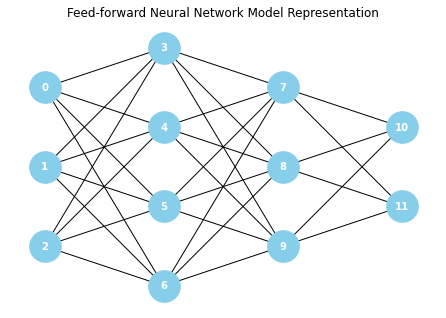

In [70]:
model = readFile('model1.txt')
#TODO: Hias lebih bagus graph (bedain bias, input, sama output)